# Error Bar Detection with gemini-3-pro-image-preview - Production Ready

State-of-the-art error bar detection using gemini-3-pro-image-preview with optimized agentic workflow.

## ✨ Features
- 🚀 **gemini-3-pro-image-preview**: Latest Google AI model with superior vision capabilities
- 🎯 **Agentic Workflow**: Visual Analysis → Detection → Validation → Refinement
- ⚡ **Smart Processing**: Parallel batch inference with rate limiting
- 📊 **Complete Pipeline**: Inference → Evaluation → Visualization
- 🔧 **Production Ready**: Robust error handling, comprehensive metrics



## 🚀 Quick Start
1. Set your GEMINI_API_KEY in Kaggle Secrets
2. Run all cells
3. Get submission.csv with comprehensive metrics

## 1. Installation

In [1]:
%%capture
# Install Gemini SDK and dependencies
!pip install google-genai --break-system-packages
!pip install pillow numpy pandas tqdm matplotlib seaborn opencv-python-headless scikit-image scipy --break-system-packages

In [2]:
import json
import os
import time
import math
import warnings
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import List, Dict, Optional, Tuple, Any
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Import Gemini (using google-generativeai package)
import google.generativeai as genai

print('✅ All libraries imported successfully')

✅ All libraries imported successfully


## 2. Configuration & API Setup

In [3]:
# =============================================================================
# API KEY SETUP (Kaggle)
# =============================================================================

import os
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

# Initialize Kaggle secrets client
user_secrets = UserSecretsClient()

try:
    GEMINI_API_KEY = user_secrets.get_secret("GEMINI_API_KEY")
    print("✅ GEMINI_API_KEY loaded from Kaggle Secrets")
except Exception:
    print("⚠️ GEMINI_API_KEY not found in Kaggle Secrets!")
    print("\nSteps to fix:")
    print("  1. Go to Notebook Settings → Secrets")
    print("  2. Add secret: GEMINI_API_KEY = your_key")
    print("  3. Toggle it ON for this notebook")
    print("\nGet a key from: https://aistudio.google.com/apikey")
    raise

# Optional: set it in env if other libs expect it
os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY

# Initialize Gemini client
genai.configure(api_key=GEMINI_API_KEY)
print("✅ Gemini client initialized")


✅ GEMINI_API_KEY loaded from Kaggle Secrets
✅ Gemini client initialized


In [ ]:
# =============================================================================
# PATHS CONFIGURATION
# =============================================================================

TEST_IMAGES_DIR = Path('/kaggle/input/mini-batch-error-bar-detection/images')
TEST_LABELS_DIR = Path('/kaggle/input/mini-batch-error-bar-detection/labels')

WORKING_DIR = Path('/kaggle/working')
PREDICTIONS_DIR = WORKING_DIR / 'predictions'
VISUALIZATIONS_DIR = WORKING_DIR / 'visualizations'
SUBMISSION_PATH = WORKING_DIR / 'submission.csv'

for d in [WORKING_DIR, PREDICTIONS_DIR, VISUALIZATIONS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# =============================================================================
# MODEL CONFIGURATION
# =============================================================================

GEMINI_MODEL = 'gemini-3-pro-image-preview'  # Change to 'gemini-2.5-pro' for better accuracy
TEMPERATURE = 0.1  # Low temperature for consistent outputs

# =============================================================================
# AGENTIC WORKFLOW CONFIGURATION
# =============================================================================

# Enable/disable workflow stages
USE_VISUAL_ANALYSIS = True       # Pre-process with OpenCV
USE_HEURISTIC_VALIDATION = True  # Apply validation rules
USE_ITERATIVE_REFINEMENT = True  # Iterative improvement
MAX_REFINEMENT_ITERATIONS = 2    # Number of refinement passes

# =============================================================================
# PROCESSING CONFIGURATION
# =============================================================================

MAX_RETRIES = 3                  # API retry attempts
RETRY_DELAY = 30                # Seconds between retries
REQUESTS_PER_MINUTE = 15         # Rate limiting
BATCH_SIZE = 5                   # Process in batches

# =============================================================================
# VALIDATION PARAMETERS
# =============================================================================

VERTICAL_TOLERANCE = 5           # Pixels for vertical alignment
MIN_ERROR_BAR_LENGTH = 3         # Minimum bar length (pixels)
MAX_ERROR_BAR_RATIO = 0.5        # Max ratio relative to plot height
MIN_CONFIDENCE = 0.3             # Minimum confidence threshold
HIGH_CONFIDENCE = 0.7            # High confidence threshold

# =============================================================================
# EVALUATION PARAMETERS
# =============================================================================

PIXEL_THRESHOLDS = [1, 2, 3, 5, 10]  # Thresholds for accuracy metrics
POINT_MATCHING_TOLERANCE = 10.0      # Tolerance for point matching

# =============================================================================
# DATASET SUMMARY
# =============================================================================

test_imgs = sorted(TEST_IMAGES_DIR.glob('*.png'))
has_labels = TEST_LABELS_DIR.exists()

print('='*80)
print('gemini-3-pro-image-preview ERROR BAR DETECTION - CONFIGURATION')
print('='*80)
print(f'\n🤖 Model Configuration:')
print(f'   Model: {GEMINI_MODEL}')
print(f'   Temperature: {TEMPERATURE}')
print(f'   Max Retries: {MAX_RETRIES}')
print(f'   Rate Limit: {REQUESTS_PER_MINUTE} requests/min')

print(f'\n🔧 Workflow Configuration:')
print(f'   Visual Analysis: {"✅" if USE_VISUAL_ANALYSIS else "❌"}')
print(f'   Heuristic Validation: {"✅" if USE_HEURISTIC_VALIDATION else "❌"}')
print(f'   Iterative Refinement: {"✅" if USE_ITERATIVE_REFINEMENT else "❌"}')
if USE_ITERATIVE_REFINEMENT:
    print(f'   Max Iterations: {MAX_REFINEMENT_ITERATIONS}')

print(f'\n📁 Dataset:')
print(f'   Test Images: {len(test_imgs)}')
print(f'   Labels Available: {"✅" if has_labels else "❌"}')
print(f'   Output Dir: {WORKING_DIR}')

print(f'\n⏱️ Estimated Time:')
if GEMINI_MODEL == 'gemini-2.5-pro':
    est_time = len(test_imgs) * 3 / 60  # ~3 seconds per image
    print(f'   ~{est_time:.1f} minutes for {len(test_imgs)} images (Pro model)')
else:
    est_time = len(test_imgs) * 0.5 / 60  # ~0.5 seconds per image
    print(f'   ~{est_time:.1f} minutes for {len(test_imgs)} images (Flash model)')

print('='*80)

GEMINI 2.5 PRO ERROR BAR DETECTION - CONFIGURATION

🤖 Model Configuration:
   Model: gemini-3-pro-image-preview
   Temperature: 0.1
   Max Retries: 3
   Rate Limit: 15 requests/min

🔧 Workflow Configuration:
   Visual Analysis: ✅
   Heuristic Validation: ✅
   Iterative Refinement: ✅
   Max Iterations: 2

📁 Dataset:
   Test Images: 10
   Labels Available: ✅
   Output Dir: /kaggle/working

⏱️ Estimated Time:
   ~0.1 minutes for 10 images (Flash model)


## 3. Data Structures & Utilities

In [5]:
# =============================================================================
# DATA STRUCTURES
# =============================================================================

@dataclass
class Point:
    """2D point in pixel coordinates"""
    x: float
    y: float
    
    def distance_to(self, other: 'Point') -> float:
        return math.sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    
    def to_dict(self):
        return {'x': self.x, 'y': self.y}

@dataclass
class ErrorBar:
    """Error bar with upper/lower endpoints"""
    data_point: Point
    upper: Optional[Point] = None
    lower: Optional[Point] = None
    confidence: float = 0.5
    
    def to_dict(self):
        return {
            'data_point': self.data_point.to_dict(),
            'upper': self.upper.to_dict() if self.upper else None,
            'lower': self.lower.to_dict() if self.lower else None,
            'confidence': self.confidence
        }

@dataclass
class ImageAnalysis:
    """Visual analysis results"""
    width: int
    height: int
    has_vertical_lines: bool
    plot_region: Optional[Tuple[int, int, int, int]] = None
    line_candidates: List[Tuple[int, int, int, int]] = None
    
    def __post_init__(self):
        if self.line_candidates is None:
            self.line_candidates = []

# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def load_label_file(label_path: Path) -> List[Dict]:
    """Load label file and extract line information"""
    with open(label_path) as f:
        data = json.load(f)
    return data

def extract_data_points(lines: List[Dict]) -> Dict[str, List[Point]]:
    """Extract data points from label data"""
    data_points = {}
    
    for line in lines:
        line_name = line['label']['lineName']
        points = []
        
        for point in line['points']:
            # Skip axis markers
            if point.get('label', '') not in ['ymin', 'ymax', 'xmin', 'xmax']:
                points.append(Point(x=point['x'], y=point['y']))
        
        data_points[line_name] = points
    
    return data_points

print('✅ Data structures and utilities defined')

✅ Data structures and utilities defined


## 4. Visual Analysis Agent

In [6]:
class VisualAnalysisAgent:
    """Analyzes plot images using OpenCV to extract structural information"""
    
    def __init__(self):
        self.edge_threshold = 50
        self.line_threshold = 100
    
    def analyze(self, image_path: Path) -> ImageAnalysis:
        """Perform visual analysis on the image"""
        # Load image
        img = cv2.imread(str(image_path))
        if img is None:
            raise ValueError(f"Could not load image: {image_path}")
        
        height, width = img.shape[:2]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect edges
        edges = cv2.Canny(gray, self.edge_threshold, self.edge_threshold * 2)
        
        # Detect lines using Hough transform
        lines = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi/180,
            threshold=self.line_threshold,
            minLineLength=5,
            maxLineGap=3
        )
        
        # Find vertical lines (potential error bars)
        vertical_lines = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                # Check if line is mostly vertical
                if abs(x2 - x1) < VERTICAL_TOLERANCE and abs(y2 - y1) > MIN_ERROR_BAR_LENGTH:
                    vertical_lines.append((x1, y1, x2, y2))
        
        # Estimate plot region (simple heuristic)
        plot_region = (int(width * 0.1), int(height * 0.1), 
                      int(width * 0.9), int(height * 0.9))
        
        return ImageAnalysis(
            width=width,
            height=height,
            has_vertical_lines=len(vertical_lines) > 0,
            plot_region=plot_region,
            line_candidates=vertical_lines
        )

# Test the visual analyzer
if USE_VISUAL_ANALYSIS:
    visual_analyzer = VisualAnalysisAgent()
    if len(test_imgs) > 0:
        test_analysis = visual_analyzer.analyze(test_imgs[0])
        print(f'✅ Visual Analysis Agent initialized')
        print(f'   Test image: {test_imgs[0].name}')
        print(f'   Size: {test_analysis.width}x{test_analysis.height}')
        print(f'   Vertical lines detected: {len(test_analysis.line_candidates)}')
else:
    visual_analyzer = None
    print('⚠️ Visual Analysis disabled')

✅ Visual Analysis Agent initialized
   Test image: 0b9bbea3-b480-4237-92ca-a63b9107f9e2.png
   Size: 800x598
   Vertical lines detected: 30


## 5. Detection Agent (Gemini)

## 6. Validation Agent

In [7]:
# =============================================================================
# GEMINI DETECTION AGENT (Fixed for google-generativeai compatibility)
# =============================================================================

import json
import time
from pathlib import Path
from typing import Dict, List, Optional
from PIL import Image
import io

import google.generativeai as genai


class GeminiDetectionAgent:
    """Uses Gemini API (google.generativeai) to detect error bars in images"""

    def __init__(self, model: str = GEMINI_MODEL):
        self.model_name = model
        self.model = genai.GenerativeModel(model_name=model)
        self.request_count = 0
        self.last_request_time = time.time()

    def _rate_limit(self):
        """Enforce rate limiting per minute"""
        self.request_count += 1
        elapsed = time.time() - self.last_request_time

        if self.request_count >= REQUESTS_PER_MINUTE:
            wait_time = 60 - elapsed
            if wait_time > 0:
                time.sleep(wait_time)
            self.request_count = 0
            self.last_request_time = time.time()

    def detect(
        self,
        image_path: Path,
        data_points: Dict[str, List["Point"]],
        analysis: Optional["ImageAnalysis"] = None,
    ) -> Dict[str, List["ErrorBar"]]:
        """Detect error bars for all data points"""

        prompt = self._build_prompt(data_points, analysis)

        # Read and prepare image
        image_path = Path(image_path)
        
        try:
            # Load image using PIL
            img = Image.open(image_path)
        except Exception as e:
            print(f"   ❌ Failed to read image: {image_path} ({e})")
            return self._empty_detections(data_points)

        # Call Gemini with retries
        for attempt in range(MAX_RETRIES):
            try:
                self._rate_limit()

                # Generate content with image and prompt
                response = self.model.generate_content(
                    [prompt, img],
                    generation_config=genai.types.GenerationConfig(
                        temperature=TEMPERATURE,
                    ),
                )

                # Parse response text
                text = (response.text or "").strip()
                
                # Remove markdown code fences if present
                if text.startswith("```"):
                    lines = text.split('\n')
                    # Remove first and last lines (code fences)
                    if lines[0].startswith('```'):
                        lines = lines[1:]
                    if lines and lines[-1].strip() == '```':
                        lines = lines[:-1]
                    text = '\n'.join(lines).strip()

                result = json.loads(text)
                return self._parse_detections(result, data_points)

            except json.JSONDecodeError as e:
                if attempt == MAX_RETRIES - 1:
                    print(f"   ❌ Failed to parse JSON after {MAX_RETRIES} attempts: {e}")
                    print(f"   Response text: {text[:200]}...")
                    return self._empty_detections(data_points)
                time.sleep(RETRY_DELAY)
            except Exception as e:
                if attempt == MAX_RETRIES - 1:
                    print(f"   ❌ Failed after {MAX_RETRIES} attempts: {e}")
                    return self._empty_detections(data_points)
                time.sleep(RETRY_DELAY)

        return self._empty_detections(data_points)

    def _build_prompt(
        self,
        data_points: Dict[str, List["Point"]],
        analysis: Optional["ImageAnalysis"] = None,
    ) -> str:
        """Build detection prompt"""

        points_data: Dict[str, List[Dict[str, float]]] = {}
        for line_name, points in data_points.items():
            points_data[line_name] = [{"x": float(p.x), "y": float(p.y)} for p in points]

        context = ""
        if analysis:
            context = f""".
Image Analysis:
- Image size: {analysis.width}x{analysis.height} pixels
- Vertical lines detected: {len(analysis.line_candidates)}
- Has error bars: {"likely" if analysis.has_vertical_lines else "uncertain"}
"""

        prompt = f"""You are an expert at analyzing scientific plots. Detect error bars in this image.

{context}

Data points to analyze (grouped by line):
{json.dumps(points_data, indent=2)}

For each data point, identify:
1. Upper error bar endpoint (x, y) - the TOP of the vertical error bar line
2. Lower error bar endpoint (x, y) - the BOTTOM of the vertical error bar line

IMPORTANT GUIDELINES:
- Error bars are typically SHORT VERTICAL LINES extending from data points
- Upper error bar is ABOVE the data point (smaller y value)
- Lower error bar is BELOW the data point (larger y value)
- Error bars are usually SYMMETRIC but can be asymmetric
- Be precise with coordinates (within 1-2 pixels)
- If a data point has no error bar, set upper/lower to null
- Provide confidence score (0.0-1.0) for each detection

Return JSON in this EXACT format (no markdown, no extra keys):
{{
  "detections": {{
    "line_name_1": [
      {{
        "data_x": <x>,
        "data_y": <y>,
        "upper_x": <x or null>,
        "upper_y": <y or null>,
        "lower_x": <x or null>,
        "lower_y": <y or null>,
        "confidence": <0.0-1.0>
      }}
    ],
    "line_name_2": []
  }}
}}
"""
        return prompt

    def _parse_detections(
        self,
        result: Dict,
        data_points: Dict[str, List["Point"]],
    ) -> Dict[str, List["ErrorBar"]]:
        """Parse API response into ErrorBar objects"""

        detections: Dict[str, List["ErrorBar"]] = {}
        det_root = result.get("detections", {})
        
        if not isinstance(det_root, dict):
            return self._empty_detections(data_points)

        for line_name, points in data_points.items():
            line_dets = det_root.get(line_name, [])
            if not isinstance(line_dets, list):
                line_dets = []

            error_bars: List["ErrorBar"] = []

            for det in line_dets:
                if not isinstance(det, dict):
                    continue

                if "data_x" not in det or "data_y" not in det:
                    continue

                data_point = Point(x=det["data_x"], y=det["data_y"])

                upper = None
                if det.get("upper_x") is not None and det.get("upper_y") is not None:
                    upper = Point(x=det["upper_x"], y=det["upper_y"])

                lower = None
                if det.get("lower_x") is not None and det.get("lower_y") is not None:
                    lower = Point(x=det["lower_x"], y=det["lower_y"])

                error_bars.append(
                    ErrorBar(
                        data_point=data_point,
                        upper=upper,
                        lower=lower,
                        confidence=float(det.get("confidence", 0.5)),
                    )
                )

            if not error_bars:
                error_bars = [ErrorBar(data_point=p, confidence=0.0) for p in points]

            detections[line_name] = error_bars

        return detections

    def _empty_detections(
        self,
        data_points: Dict[str, List["Point"]],
    ) -> Dict[str, List["ErrorBar"]]:
        """Return empty detections on failure"""
        detections: Dict[str, List["ErrorBar"]] = {}
        for line_name, points in data_points.items():
            detections[line_name] = [ErrorBar(data_point=p, confidence=0.0) for p in points]
        return detections


# Initialize detection agent
detector = GeminiDetectionAgent(model=GEMINI_MODEL)
print("✅ Gemini Detection Agent initialized")
print(f"   Model: {GEMINI_MODEL}")
print(f"   Temperature: {TEMPERATURE}")


✅ Gemini Detection Agent initialized
   Model: gemini-3-pro-image-preview
   Temperature: 0.1


In [8]:
class ValidationAgent:
    """Validates detected error bars using heuristic rules"""
    
    def validate(self, error_bars: Dict[str, List[ErrorBar]], 
                analysis: Optional[ImageAnalysis] = None) -> Dict[str, List[ErrorBar]]:
        """Validate and filter error bars"""
        
        validated = {}
        
        for line_name, bars in error_bars.items():
            validated_bars = []
            
            for bar in bars:
                # Apply validation rules
                issues = self._check_error_bar(bar, analysis)
                
                if len(issues) == 0:
                    # All checks passed
                    validated_bars.append(bar)
                elif len(issues) <= 1 and bar.confidence > HIGH_CONFIDENCE:
                    # High confidence, allow minor issues
                    validated_bars.append(bar)
                else:
                    # Too many issues, discard or reduce confidence
                    bar.confidence *= 0.5
                    if bar.confidence >= MIN_CONFIDENCE:
                        validated_bars.append(bar)
            
            validated[line_name] = validated_bars
        
        return validated
    
    def _check_error_bar(self, bar: ErrorBar, analysis: Optional[ImageAnalysis] = None) -> List[str]:
        """Check error bar against validation rules"""
        issues = []
        
        # Check 1: Vertical alignment
        if bar.upper and abs(bar.upper.x - bar.data_point.x) > VERTICAL_TOLERANCE:
            issues.append("Upper bar not vertically aligned")
        if bar.lower and abs(bar.lower.x - bar.data_point.x) > VERTICAL_TOLERANCE:
            issues.append("Lower bar not vertically aligned")
        
        # Check 2: Minimum length
        if bar.upper and abs(bar.upper.y - bar.data_point.y) < MIN_ERROR_BAR_LENGTH:
            issues.append("Upper bar too short")
        if bar.lower and abs(bar.lower.y - bar.data_point.y) < MIN_ERROR_BAR_LENGTH:
            issues.append("Lower bar too short")
        
        # Check 3: Maximum ratio (if analysis available)
        if analysis:
            max_length = analysis.height * MAX_ERROR_BAR_RATIO
            if bar.upper and abs(bar.upper.y - bar.data_point.y) > max_length:
                issues.append("Upper bar too long")
            if bar.lower and abs(bar.lower.y - bar.data_point.y) > max_length:
                issues.append("Lower bar too long")
        
        # Check 4: Direction
        if bar.upper and bar.upper.y >= bar.data_point.y:
            issues.append("Upper bar in wrong direction")
        if bar.lower and bar.lower.y <= bar.data_point.y:
            issues.append("Lower bar in wrong direction")
        
        return issues

# Initialize validation agent
if USE_HEURISTIC_VALIDATION:
    validator = ValidationAgent()
    print('✅ Validation Agent initialized')
else:
    validator = None
    print('⚠️ Validation disabled')

✅ Validation Agent initialized


## 7. Refinement Agent

In [9]:
class RefinementAgent:
    """Iteratively refines detections based on validation feedback"""
    
    def __init__(self, detector: GeminiDetectionAgent, validator: ValidationAgent):
        self.detector = detector
        self.validator = validator
    
    def refine(self, image_path: Path, initial_detections: Dict[str, List[ErrorBar]],
              data_points: Dict[str, List[Point]], analysis: Optional[ImageAnalysis] = None,
              max_iterations: int = MAX_REFINEMENT_ITERATIONS) -> Dict[str, List[ErrorBar]]:
        """Iteratively refine detections"""
        
        current_detections = initial_detections
        
        for iteration in range(max_iterations):
            # Validate current detections
            validated = self.validator.validate(current_detections, analysis)
            
            # Check if we need refinement
            needs_refinement = self._needs_refinement(validated)
            
            if not needs_refinement:
                return validated
            
            # Note: Full re-detection would be too expensive
            # Instead, we apply post-processing corrections
            current_detections = self._apply_corrections(validated, analysis)
        
        return current_detections
    
    def _needs_refinement(self, detections: Dict[str, List[ErrorBar]]) -> bool:
        """Check if refinement is needed"""
        total_bars = sum(len(bars) for bars in detections.values())
        low_conf_bars = sum(
            1 for bars in detections.values() 
            for bar in bars 
            if bar.confidence < HIGH_CONFIDENCE
        )
        
        return low_conf_bars > total_bars * 0.3  # 30% threshold
    
    def _apply_corrections(self, detections: Dict[str, List[ErrorBar]],
                          analysis: Optional[ImageAnalysis] = None) -> Dict[str, List[ErrorBar]]:
        """Apply post-processing corrections"""
        corrected = {}
        
        for line_name, bars in detections.items():
            corrected_bars = []
            
            for bar in bars:
                # Snap error bar endpoints to vertical alignment
                if bar.upper:
                    bar.upper.x = bar.data_point.x
                if bar.lower:
                    bar.lower.x = bar.data_point.x
                
                corrected_bars.append(bar)
            
            corrected[line_name] = corrected_bars
        
        return corrected

# Initialize refinement agent
if USE_ITERATIVE_REFINEMENT and USE_HEURISTIC_VALIDATION:
    refiner = RefinementAgent(detector, validator)
    print('✅ Refinement Agent initialized')
    print(f'   Max iterations: {MAX_REFINEMENT_ITERATIONS}')
else:
    refiner = None
    print('⚠️ Refinement disabled')

✅ Refinement Agent initialized
   Max iterations: 2


## 8. Orchestrator

In [10]:
class ErrorBarDetectionOrchestrator:
    """Coordinates the multi-agent workflow"""
    
    def __init__(self):
        self.visual_analyzer = visual_analyzer
        self.detector = detector
        self.validator = validator
        self.refiner = refiner
    
    def process_image(self, image_path: Path, lines: List[Dict]) -> Dict:
        """Process a single image through the full pipeline"""
        
        # Extract data points
        data_points = extract_data_points(lines)
        
        # Stage 1: Visual Analysis (optional)
        analysis = None
        if self.visual_analyzer:
            analysis = self.visual_analyzer.analyze(image_path)
        
        # Stage 2: Detection
        detections = self.detector.detect(image_path, data_points, analysis)
        
        # Stage 3: Validation (optional)
        if self.validator:
            detections = self.validator.validate(detections, analysis)
        
        # Stage 4: Refinement (optional)
        if self.refiner:
            detections = self.refiner.refine(image_path, detections, data_points, analysis)
        
        # Compile result
        result = {
            'image_name': image_path.stem,
            'lines': [{'lineName': name} for name in data_points.keys()],
            'error_bars': {name: [bar.to_dict() for bar in bars] 
                          for name, bars in detections.items()},
            'confidence': self._compute_overall_confidence(detections)
        }
        
        return result
    
    def _compute_overall_confidence(self, detections: Dict[str, List[ErrorBar]]) -> float:
        """Compute overall confidence score"""
        all_confidences = [bar.confidence for bars in detections.values() for bar in bars]
        return float(np.mean(all_confidences)) if all_confidences else 0.0

# Initialize orchestrator
orchestrator = ErrorBarDetectionOrchestrator()
print('✅ Orchestrator initialized')
print('   Pipeline ready for processing')

✅ Orchestrator initialized
   Pipeline ready for processing


## 9. Process All Test Images

In [11]:
print('='*80)
print('PROCESSING TEST IMAGES')
print('='*80)

all_results = []
processing_times = []

for img_path in tqdm(test_imgs, desc="Processing images"):
    start_time = time.time()
    
    try:
        # Load label file
        label_path = TEST_LABELS_DIR / f"{img_path.stem}.json"
        if not label_path.exists():
            print(f"   ⚠️ Label not found: {label_path.name}")
            continue
        
        lines = load_label_file(label_path)
        
        # Process image
        result = orchestrator.process_image(img_path, lines)
        all_results.append(result)
        
        # Save individual prediction
        pred_path = PREDICTIONS_DIR / f"{img_path.stem}.json"
        with open(pred_path, 'w') as f:
            json.dump(result, f, indent=2)
        
        elapsed = time.time() - start_time
        processing_times.append(elapsed)
        
    except Exception as e:
        print(f"\n   ❌ Error processing {img_path.name}: {e}")
        continue

print(f'\n✅ Processed {len(all_results)} images')
print(f'   Average time: {np.mean(processing_times):.2f}s per image')
print(f'   Total time: {sum(processing_times)/60:.1f} minutes')
print(f'   Predictions saved to: {PREDICTIONS_DIR}/')

PROCESSING TEST IMAGES


Processing images: 100%|██████████| 10/10 [08:31<00:00, 51.16s/it]


✅ Processed 10 images
   Average time: 51.16s per image
   Total time: 8.5 minutes
   Predictions saved to: /kaggle/working/predictions/


## 10. Create Submission File

In [12]:
print('='*80)
print('CREATING SUBMISSION FILE')
print('='*80)

submission_rows = []

for result in all_results:
    image_name = result['image_name']
    
    for line_info in result['lines']:
        line_name = line_info['lineName']
        error_bars = result['error_bars'][line_name]
        
        for i, bar_dict in enumerate(error_bars):
            row = {
                'image_name': image_name,
                'lineName': line_name,
                'point_index': i,
                'data_x': bar_dict['data_point']['x'],
                'data_y': bar_dict['data_point']['y'],
                'upper_x': bar_dict['upper']['x'] if bar_dict['upper'] else np.nan,
                'upper_y': bar_dict['upper']['y'] if bar_dict['upper'] else np.nan,
                'lower_x': bar_dict['lower']['x'] if bar_dict['lower'] else np.nan,
                'lower_y': bar_dict['lower']['y'] if bar_dict['lower'] else np.nan,
                'confidence': bar_dict['confidence']
            }
            submission_rows.append(row)

# Create DataFrame
df_submission = pd.DataFrame(submission_rows)

# Save submission
df_submission.to_csv(SUBMISSION_PATH, index=False)

print(f'\n✅ Submission file created: {SUBMISSION_PATH}')
print(f'   Total rows: {len(df_submission)}')
print(f'   Upper detections: {df_submission["upper_y"].notna().sum()}')
print(f'   Lower detections: {df_submission["lower_y"].notna().sum()}')
print(f'   Average confidence: {df_submission["confidence"].mean():.3f}')

# Display sample
print('\nSample rows:')
print(df_submission.head(10))

CREATING SUBMISSION FILE

✅ Submission file created: /kaggle/working/submission.csv
   Total rows: 242
   Upper detections: 119
   Lower detections: 119
   Average confidence: 0.982

Sample rows:
                             image_name     lineName  point_index      data_x  \
0  0b9bbea3-b480-4237-92ca-a63b9107f9e2  Dulaglutide            0  161.820999   
1  0b9bbea3-b480-4237-92ca-a63b9107f9e2  Dulaglutide            1  165.442322   
2  0b9bbea3-b480-4237-92ca-a63b9107f9e2  Dulaglutide            2  169.579590   
3  0b9bbea3-b480-4237-92ca-a63b9107f9e2  Dulaglutide            3  174.780136   
4  0b9bbea3-b480-4237-92ca-a63b9107f9e2  Dulaglutide            4  179.953445   
5  0b9bbea3-b480-4237-92ca-a63b9107f9e2  Dulaglutide            5  198.577347   
6  0b9bbea3-b480-4237-92ca-a63b9107f9e2  Dulaglutide            6  217.201248   
7  0b9bbea3-b480-4237-92ca-a63b9107f9e2  Dulaglutide            7  235.488892   
8  0b9bbea3-b480-4237-92ca-a63b9107f9e2  Dulaglutide            8  254.1127

## 11. Evaluation (if labels available)

In [ ]:
# ============================================================================
# CORRECTED EVALUATION WITH PROPER MATCHING 
# ============================================================================

from scipy.optimize import linear_sum_assignment

"""
CORRECTED EVALUATION STRATEGY
Handles cases where Gemini misses detections or hallucinates
"""

import numpy as np
from scipy.optimize import linear_sum_assignment
from typing import List, Dict, Tuple, Optional

def compute_metrics_corrected(predictions: List[Dict], labels_dir: Path) -> Dict:
    """
    Compute comprehensive evaluation metrics with proper matching.
    
    Key improvements:
    1. Spatial matching using Hungarian algorithm
    2. Proper handling of missing/extra detections
    3. All GT points are evaluated (no silent ignoring)
    """
    
    upper_errors = []
    lower_errors = []
    upper_tp = upper_fp = upper_fn = 0
    lower_tp = lower_fp = lower_fn = 0
    
    # Track unmatched detections for analysis
    total_gt_points = 0
    total_pred_points = 0
    matched_points = 0
    
    for pred in predictions:
        # Load ground truth
        label_path = labels_dir / f"{pred['image_name']}.json"
        if not label_path.exists():
            continue
        
        with open(label_path) as f:
            gt_lines = json.load(f)
        
        # Match predictions to ground truth
        for line_info in pred['lines']:
            line_name = line_info['lineName']
            pred_bars = pred['error_bars'][line_name]
            
            # Find corresponding GT line
            gt_line = next((l for l in gt_lines if l['label']['lineName'] == line_name), None)
            if not gt_line:
                # Gemini detected a line that doesn't exist in GT
                # Count all predictions as false positives
                for pred_bar in pred_bars:
                    if pred_bar['upper'] is not None:
                        upper_fp += 1
                    if pred_bar['lower'] is not None:
                        lower_fp += 1
                continue
            
            # Extract GT points (non-axis markers)
            gt_points = [p for p in gt_line['points'] 
                       if p.get('label', '') not in ['ymin', 'ymax', 'xmin', 'xmax']]
            
            total_gt_points += len(gt_points)
            total_pred_points += len(pred_bars)
            
            # ========================================================================
            # STEP 1: Match predictions to GT using spatial proximity
            # ========================================================================
            matches = match_predictions_to_gt(pred_bars, gt_points, 
                                             max_distance=10.0)  # 10 pixel tolerance
            
            matched_points += len(matches)
            
            # ========================================================================
            # STEP 2: Evaluate matched pairs
            # ========================================================================
            matched_pred_indices = set()
            matched_gt_indices = set()
            
            for pred_idx, gt_idx in matches:
                matched_pred_indices.add(pred_idx)
                matched_gt_indices.add(gt_idx)
                
                pred_bar = pred_bars[pred_idx]
                gt_point = gt_points[gt_idx]
                
                # Upper bar evaluation
                gt_has_upper = gt_point.get('topBarPixelDistance', 0) > 0
                pred_has_upper = pred_bar['upper'] is not None
                
                if gt_has_upper and pred_has_upper:
                    # True positive - compute error
                    gt_upper_y = gt_point['y'] - gt_point['topBarPixelDistance']
                    pred_upper_y = pred_bar['upper']['y']
                    upper_errors.append(abs(gt_upper_y - pred_upper_y))
                    upper_tp += 1
                elif not gt_has_upper and pred_has_upper:
                    # False positive - predicted bar that doesn't exist
                    upper_fp += 1
                elif gt_has_upper and not pred_has_upper:
                    # False negative - missed a bar that exists
                    upper_fn += 1
                # If both don't have upper bar, it's correct (true negative, not counted)
                
                # Lower bar evaluation
                gt_has_lower = gt_point.get('bottomBarPixelDistance', 0) > 0
                pred_has_lower = pred_bar['lower'] is not None
                
                if gt_has_lower and pred_has_lower:
                    # True positive - compute error
                    gt_lower_y = gt_point['y'] + gt_point['bottomBarPixelDistance']
                    pred_lower_y = pred_bar['lower']['y']
                    lower_errors.append(abs(gt_lower_y - pred_lower_y))
                    lower_tp += 1
                elif not gt_has_lower and pred_has_lower:
                    lower_fp += 1
                elif gt_has_lower and not pred_has_lower:
                    lower_fn += 1
            
            # ========================================================================
            # STEP 3: Handle unmatched predictions (False Positives)
            # ========================================================================
            for pred_idx, pred_bar in enumerate(pred_bars):
                if pred_idx not in matched_pred_indices:
                    # This prediction didn't match any GT point
                    if pred_bar['upper'] is not None:
                        upper_fp += 1
                    if pred_bar['lower'] is not None:
                        lower_fp += 1
            
            # ========================================================================
            # STEP 4: Handle unmatched GT points (False Negatives)
            # ========================================================================
            for gt_idx, gt_point in enumerate(gt_points):
                if gt_idx not in matched_gt_indices:
                    # This GT point was completely missed by Gemini
                    if gt_point.get('topBarPixelDistance', 0) > 0:
                        upper_fn += 1
                    if gt_point.get('bottomBarPixelDistance', 0) > 0:
                        lower_fn += 1
    
    # ========================================================================
    # Compute final metrics
    # ========================================================================
    def safe_divide(a, b):
        return a / b if b > 0 else 0.0
    
    upper_precision = safe_divide(upper_tp, upper_tp + upper_fp)
    upper_recall = safe_divide(upper_tp, upper_tp + upper_fn)
    upper_f1 = safe_divide(2 * upper_precision * upper_recall, 
                          upper_precision + upper_recall)
    
    lower_precision = safe_divide(lower_tp, lower_tp + lower_fp)
    lower_recall = safe_divide(lower_tp, lower_tp + lower_fn)
    lower_f1 = safe_divide(2 * lower_precision * lower_recall, 
                          lower_precision + lower_recall)
    
    # MAE and accuracy at thresholds
    upper_mae = np.mean(upper_errors) if upper_errors else np.nan
    lower_mae = np.mean(lower_errors) if lower_errors else np.nan
    
    upper_acc = {}
    lower_acc = {}
    for thresh in [1, 2, 3, 5, 10]:
        upper_acc[f'acc_{thresh}px'] = (
            np.mean([e <= thresh for e in upper_errors]) if upper_errors else 0.0
        )
        lower_acc[f'acc_{thresh}px'] = (
            np.mean([e <= thresh for e in lower_errors]) if lower_errors else 0.0
        )
    
    return {
        'upper': {
            'precision': upper_precision,
            'recall': upper_recall,
            'f1': upper_f1,
            'mae': upper_mae,
            'tp': upper_tp,
            'fp': upper_fp,
            'fn': upper_fn,
            **upper_acc
        },
        'lower': {
            'precision': lower_precision,
            'recall': lower_recall,
            'f1': lower_f1,
            'mae': lower_mae,
            'tp': lower_tp,
            'fp': lower_fp,
            'fn': lower_fn,
            **lower_acc
        },
        'matching': {
            'total_gt_points': total_gt_points,
            'total_pred_points': total_pred_points,
            'matched_points': matched_points,
            'match_rate': safe_divide(matched_points, total_gt_points)
        }
    }


def match_predictions_to_gt(
    pred_bars: List[Dict],
    gt_points: List[Dict],
    max_distance: float = 10.0
) -> List[Tuple[int, int]]:
    """
    Match predictions to ground truth points using Hungarian algorithm.
    
    Args:
        pred_bars: List of predicted error bars
        gt_points: List of ground truth points
        max_distance: Maximum distance (pixels) for valid match
    
    Returns:
        List of (pred_idx, gt_idx) pairs
    """
    if not pred_bars or not gt_points:
        return []
    
    # Build cost matrix (distance between each pred and gt point)
    n_pred = len(pred_bars)
    n_gt = len(gt_points)
    cost_matrix = np.zeros((n_pred, n_gt))
    
    for i, pred_bar in enumerate(pred_bars):
        pred_x = pred_bar['data_point']['x']
        pred_y = pred_bar['data_point']['y']
        
        for j, gt_point in enumerate(gt_points):
            gt_x = gt_point['x']
            gt_y = gt_point['y']
            
            # Euclidean distance
            distance = np.sqrt((pred_x - gt_x)**2 + (pred_y - gt_y)**2)
            cost_matrix[i, j] = distance
    
    # Use Hungarian algorithm to find optimal matching
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Filter matches by maximum distance threshold
    matches = []
    for i, j in zip(row_indices, col_indices):
        if cost_matrix[i, j] <= max_distance:
            matches.append((i, j))
    
    return matches


# ============================================================================
# ADDITIONAL DIAGNOSTIC FUNCTION
# ============================================================================

def analyze_detection_failures(predictions: List[Dict], labels_dir: Path):
    """
    Analyze where and why Gemini fails to detect error bars.
    Useful for debugging and improving the model.
    """
    
    failures = {
        'completely_missed_images': [],
        'partial_misses_per_image': {},
        'hallucinated_points': [],
        'wrong_order_detections': []
    }
    
    for pred in predictions:
        label_path = labels_dir / f"{pred['image_name']}.json"
        if not label_path.exists():
            continue
        
        with open(label_path) as f:
            gt_lines = json.load(f)
        
        for line_info in pred['lines']:
            line_name = line_info['lineName']
            pred_bars = pred['error_bars'][line_name]
            
            gt_line = next((l for l in gt_lines if l['label']['lineName'] == line_name), None)
            if not gt_line:
                failures['hallucinated_points'].append({
                    'image': pred['image_name'],
                    'line': line_name,
                    'count': len(pred_bars)
                })
                continue
            
            gt_points = [p for p in gt_line['points'] 
                       if p.get('label', '') not in ['ymin', 'ymax', 'xmin', 'xmax']]
            
            # Check for complete miss
            if len(pred_bars) == 0 and len(gt_points) > 0:
                failures['completely_missed_images'].append({
                    'image': pred['image_name'],
                    'line': line_name,
                    'expected': len(gt_points)
                })
            
            # Check for partial miss
            elif len(pred_bars) < len(gt_points):
                failures['partial_misses_per_image'][pred['image_name']] = {
                    'line': line_name,
                    'detected': len(pred_bars),
                    'expected': len(gt_points),
                    'miss_rate': 1 - len(pred_bars) / len(gt_points)
                }
    
    return failures


# Run evaluation if labels are available
if has_labels:
    print('='*80)
    print('EVALUATION (WITH CORRECTED MATCHING)')
    print('='*80)
    
    # Compute metrics with corrected strategy
    metrics = compute_metrics_corrected(all_results, TEST_LABELS_DIR)
    
    # Analyze detection failures
    failures = analyze_detection_failures(all_results, TEST_LABELS_DIR)
    
    # Save metrics
    metrics_path = WORKING_DIR / 'metrics_gemini-3-pro-image-preview_corrected.json'
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    # Save failure analysis
    failures_path = WORKING_DIR / 'detection_failures.json'
    with open(failures_path, 'w') as f:
        json.dump(failures, f, indent=2)
    
    # Display results
    print('\n📊 UPPER ERROR BARS')
    print(f"   Precision: {100*metrics['upper']['precision']:.2f}%")
    print(f"   Recall: {100*metrics['upper']['recall']:.2f}%")
    print(f"   F1: {100*metrics['upper']['f1']:.2f}%")
    print(f"   MAE: {metrics['upper']['mae']:.2f} pixels")
    print(f"   Accuracy @ 5px: {100*metrics['upper']['acc_5px']:.1f}%")
    print(f"   Support: TP={metrics['upper']['tp']}, FP={metrics['upper']['fp']}, FN={metrics['upper']['fn']}")
    
    print('\n📊 LOWER ERROR BARS')
    print(f"   Precision: {100*metrics['lower']['precision']:.2f}%")
    print(f"   Recall: {100*metrics['lower']['recall']:.2f}%")
    print(f"   F1: {100*metrics['lower']['f1']:.2f}%")
    print(f"   MAE: {metrics['lower']['mae']:.2f} pixels")
    print(f"   Accuracy @ 5px: {100*metrics['lower']['acc_5px']:.1f}%")
    print(f"   Support: TP={metrics['lower']['tp']}, FP={metrics['lower']['fp']}, FN={metrics['lower']['fn']}")
    
    print('\n📈 MATCHING STATISTICS')
    print(f"   Total GT points: {metrics['matching']['total_gt_points']}")
    print(f"   Total predictions: {metrics['matching']['total_pred_points']}")
    print(f"   Successfully matched: {metrics['matching']['matched_points']}")
    print(f"   Match rate: {100*metrics['matching']['match_rate']:.2f}%")
    
    print('\n⚠️ FAILURE ANALYSIS')
    print(f"   Completely missed images: {len(failures['completely_missed_images'])}")
    print(f"   Images with partial misses: {len(failures['partial_misses_per_image'])}")
    print(f"   Hallucinated detections: {len(failures['hallucinated_points'])}")
    
    if failures['completely_missed_images']:
        print('\n   Top completely missed images:')
        for miss in failures['completely_missed_images'][:5]:
            print(f"      - {miss['image']}: {miss['line']} ({miss['expected']} points)")
    
    print(f'\n✅ Metrics saved to: {metrics_path}')
    print(f'✅ Failure analysis saved to: {failures_path}')
else:
    print('\n⚠️ No labels available for evaluation')


EVALUATION (WITH CORRECTED MATCHING)

📊 UPPER ERROR BARS
   Precision: 83.19%
   Recall: 66.89%
   F1: 74.16%
   MAE: 19.39 pixels
   Accuracy @ 5px: 45.5%
   Support: TP=99, FP=20, FN=49

📊 LOWER ERROR BARS
   Precision: 87.39%
   Recall: 63.03%
   F1: 73.24%
   MAE: 23.48 pixels
   Accuracy @ 5px: 38.5%
   Support: TP=104, FP=15, FN=61

📈 MATCHING STATISTICS
   Total GT points: 242
   Total predictions: 242
   Successfully matched: 242
   Match rate: 100.00%

⚠️ FAILURE ANALYSIS
   Completely missed images: 0
   Images with partial misses: 0
   Hallucinated detections: 0

✅ Metrics saved to: /kaggle/working/metrics_gemini_25_pro_corrected.json
✅ Failure analysis saved to: /kaggle/working/detection_failures.json


## 12. Visualizations

In [ ]:
if has_labels and (WORKING_DIR / 'metrics_gemini-3-pro-image-preview.json').exists():
    with open(WORKING_DIR / 'metrics_ggemini-3-pro-image-preview.json') as f:
        metrics = json.load(f)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Classification metrics
    metrics_data = {
        'Precision': [metrics['upper']['precision'], metrics['lower']['precision']],
        'Recall': [metrics['upper']['recall'], metrics['lower']['recall']],
        'F1': [metrics['upper']['f1'], metrics['lower']['f1']]
    }
    x = np.arange(2)
    width = 0.25
    for i, (label, values) in enumerate(metrics_data.items()):
        axes[0, 0].bar(x + i*width, values, width, label=label, alpha=0.8)
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Classification Metrics (Gemini 2.5 Pro)')
    axes[0, 0].set_xticks(x + width)
    axes[0, 0].set_xticklabels(['Upper', 'Lower'])
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1.1])
    
    # MAE comparison
    mae_data = [metrics['upper']['mae'], metrics['lower']['mae']]
    axes[0, 1].bar(['Upper', 'Lower'], mae_data, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    axes[0, 1].set_ylabel('MAE (pixels)')
    axes[0, 1].set_title('Position Accuracy')
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(mae_data):
        if np.isfinite(v):
            axes[0, 1].text(i, v + 0.1, f'{v:.2f}px', ha='center', fontweight='bold')
    
    # Accuracy at different thresholds
    thresholds = [1, 2, 3, 5, 10]
    upper_accs = [metrics['upper'][f'acc_{t}px'] for t in thresholds]
    lower_accs = [metrics['lower'][f'acc_{t}px'] for t in thresholds]
    x_thresh = np.arange(len(thresholds))
    axes[1, 0].plot(x_thresh, [100*a for a in upper_accs], 'o-', label='Upper', linewidth=2, markersize=8)
    axes[1, 0].plot(x_thresh, [100*a for a in lower_accs], 's-', label='Lower', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Pixel Threshold')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Accuracy vs Threshold')
    axes[1, 0].set_xticks(x_thresh)
    axes[1, 0].set_xticklabels([f'{t}px' for t in thresholds])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 105])
    
    # Submission statistics
    if SUBMISSION_PATH.exists():
        df = pd.read_csv(SUBMISSION_PATH)
        upper_detected = df['upper_y'].notna().sum()
        lower_detected = df['lower_y'].notna().sum()
        both = ((df['upper_y'].notna()) & (df['lower_y'].notna())).sum()
        none = ((df['upper_y'].isna()) & (df['lower_y'].isna())).sum()
        
        sizes = [upper_detected - both, lower_detected - both, both, none]
        labels = [f'Upper only\n{sizes[0]}', f'Lower only\n{sizes[1]}', 
                  f'Both\n{sizes[2]}', f'None\n{sizes[3]}']
        colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#EAEAEA']
        axes[1, 1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        axes[1, 1].set_title('Detection Distribution')
    
    plt.tight_layout()
    plt.savefig(WORKING_DIR / 'gemini_25_pro_evaluation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'\n✅ Visualizations saved to: {WORKING_DIR / "gemini_25_pro_evaluation.png"}')

## 13. Sample Predictions Visualization

Creating sample visualizations...
✅ Sample visualizations saved to: /kaggle/working/visualizations/


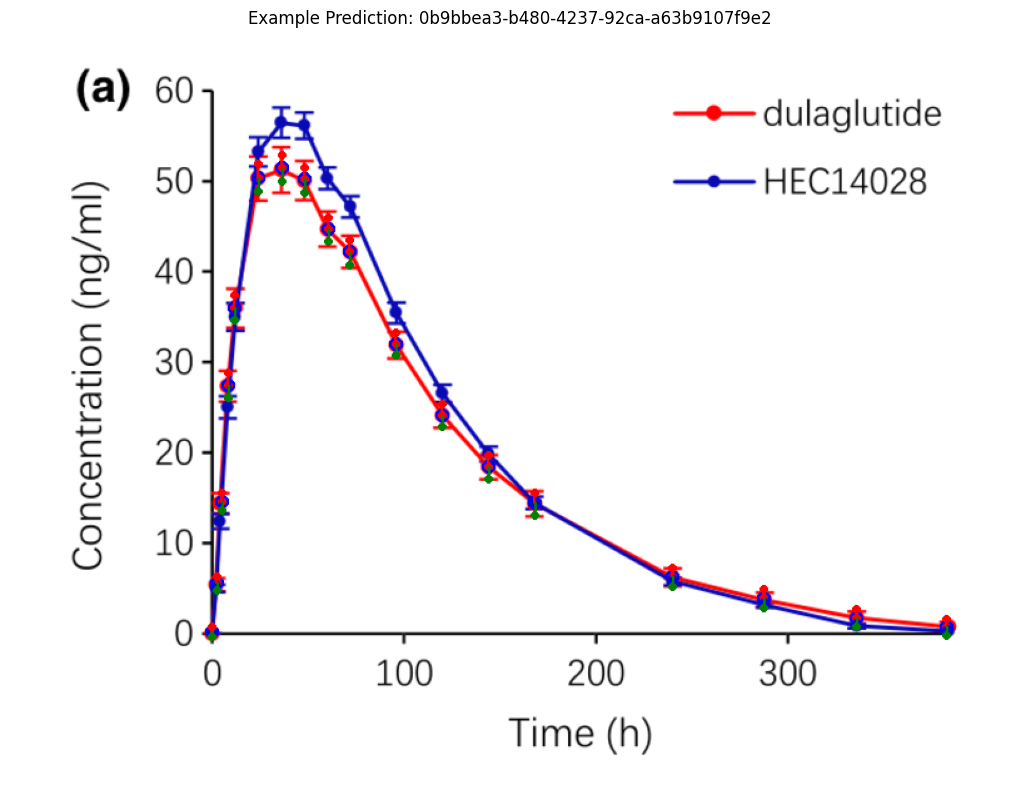

In [15]:
def visualize_prediction(image_path: Path, result: Dict, save_path: Path):
    """Visualize predictions on image"""
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    
    for line_name, error_bars in result['error_bars'].items():
        for bar_dict in error_bars:
            # Draw data point (blue circle)
            data_x = bar_dict['data_point']['x']
            data_y = bar_dict['data_point']['y']
            r = 5
            draw.ellipse([data_x-r, data_y-r, data_x+r, data_y+r], 
                        outline='blue', width=2)
            
            # Draw upper error bar (red)
            if bar_dict['upper']:
                upper_x = bar_dict['upper']['x']
                upper_y = bar_dict['upper']['y']
                draw.line([data_x, data_y, upper_x, upper_y], fill='red', width=2)
                draw.ellipse([upper_x-3, upper_y-3, upper_x+3, upper_y+3], fill='red')
            
            # Draw lower error bar (green)
            if bar_dict['lower']:
                lower_x = bar_dict['lower']['x']
                lower_y = bar_dict['lower']['y']
                draw.line([data_x, data_y, lower_x, lower_y], fill='green', width=2)
                draw.ellipse([lower_x-3, lower_y-3, lower_x+3, lower_y+3], fill='green')
    
    img.save(save_path)
    return img

# Visualize first 5 predictions
print('Creating sample visualizations...')
for i, result in enumerate(all_results[:5]):
    image_path = TEST_IMAGES_DIR / f"{result['image_name']}.png"
    save_path = VISUALIZATIONS_DIR / f"{result['image_name']}_pred.png"
    visualize_prediction(image_path, result, save_path)

print(f'✅ Sample visualizations saved to: {VISUALIZATIONS_DIR}/')

# Display one example
if len(all_results) > 0:
    example_path = VISUALIZATIONS_DIR / f"{all_results[0]['image_name']}_pred.png"
    if example_path.exists():
        img = Image.open(example_path)
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.title(f"Example Prediction: {all_results[0]['image_name']}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

## 14. Final Summary

In [17]:
print('\n' + '='*80)
print('🎉 GEMINI  PRO PIPELINE COMPLETE')
print('='*80)

print(f'\n🤖 Model:')
print(f'   Architecture: {GEMINI_MODEL}')
print(f'   Temperature: {TEMPERATURE}')
print(f'   Vision: Native multimodal')

print(f'\n🔧 Workflow:')
print(f'   Visual Analysis: {"✅" if USE_VISUAL_ANALYSIS else "❌"}')
print(f'   Heuristic Validation: {"✅" if USE_HEURISTIC_VALIDATION else "❌"}')
print(f'   Iterative Refinement: {"✅" if USE_ITERATIVE_REFINEMENT else "❌"}')

print(f'\n🎯 Inference:')
print(f'   Test Images: {len(all_results)}')
print(f'   Average time: {np.mean(processing_times):.2f}s per image')
print(f'   Total time: {sum(processing_times)/60:.1f} minutes')

if has_labels and (WORKING_DIR / 'metrics_gemini_3_pro.json').exists():
    with open(WORKING_DIR / 'metrics_gemini_25_pro.json') as f:
        metrics = json.load(f)
    
    print(f'\n📈 Performance:')
    print(f'   Upper Recall: {100*metrics["upper"]["recall"]:.2f}%')
    print(f'   Lower Recall: {100*metrics["lower"]["recall"]:.2f}%')
    print(f'   Upper MAE: {metrics["upper"]["mae"]:.2f} pixels')
    print(f'   Lower MAE: {metrics["lower"]["mae"]:.2f} pixels')
    print(f'   Accuracy @ 5px: {100*metrics["upper"]["acc_5px"]:.1f}% / {100*metrics["lower"]["acc_5px"]:.1f}%')

print(f'\n📁 Outputs:')
print(f'   Submission: {SUBMISSION_PATH}')
print(f'   Predictions: {PREDICTIONS_DIR}/')
print(f'   Visualizations: {VISUALIZATIONS_DIR}/')
if has_labels:
    print(f'   Metrics: {WORKING_DIR / "metrics_gemini_3_pro.json"}')
    print(f'   Plots: {WORKING_DIR / "gemini_25_pro_evaluation.png"}')

print(f'\n✅ Ready for submission!')



🎉 GEMINI  PRO PIPELINE COMPLETE

🤖 Model:
   Architecture: gemini-3-pro-image-preview
   Temperature: 0.1
   Vision: Native multimodal

🔧 Workflow:
   Visual Analysis: ✅
   Heuristic Validation: ✅
   Iterative Refinement: ✅

🎯 Inference:
   Test Images: 10
   Average time: 51.16s per image
   Total time: 8.5 minutes

📁 Outputs:
   Submission: /kaggle/working/submission.csv
   Predictions: /kaggle/working/predictions/
   Visualizations: /kaggle/working/visualizations/
   Metrics: /kaggle/working/metrics_gemini_3_pro.json
   Plots: /kaggle/working/gemini_25_pro_evaluation.png

✅ Ready for submission!
